# Imports and Constants

In [1]:
import sys
# sys.path is a list of absolute path strings
sys.path.append('..')

import rhythm_regression.notebook_tools as nbt

import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random

RANDOM_SEED = 7202001  # Release Date of Spirited Away

In [2]:
with open( "example_set.pickle", "rb" ) as f:
    example_set = np.array(pickle.load(f), dtype=object)

print(len(example_set))
parameter_table = pd.read_csv('./generated_data_params.csv', index_col=0)
parameter_table.index.name = 'example_id'
print(len(parameter_table))
parameter_table.head()

484000
484000


,deletion_rate,insertion_rate,m_notes,observation_num,space_augmentation_rate,space_reduction_rate
example_id,,,,,,
0,0.0,0.0,50,0,0.0,0.000
1,0.0,0.0,50,0,0.0,0.001
2,0.0,0.0,50,0,0.0,0.002
3,0.0,0.0,50,0,0.0,0.003
4,0.0,0.0,50,0,0.0,0.004


c:\Users\prest\Desktop\rhythm_regression\vector_matching\..\rhythm_regression\notebook_tools.py:189: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


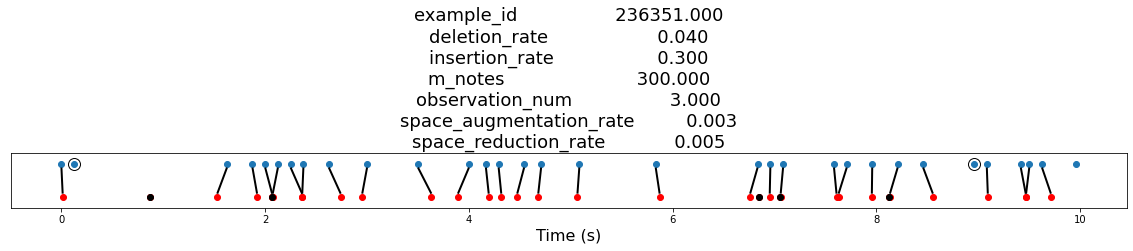

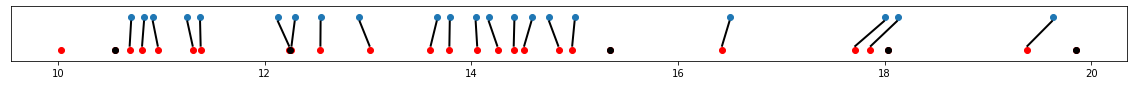

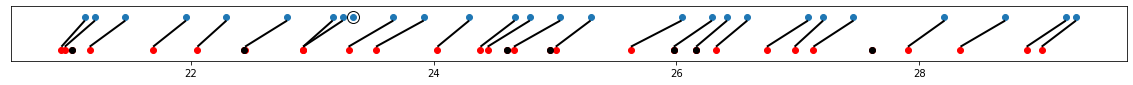

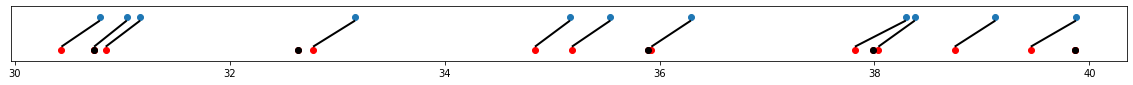

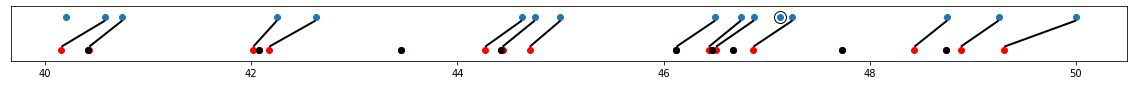

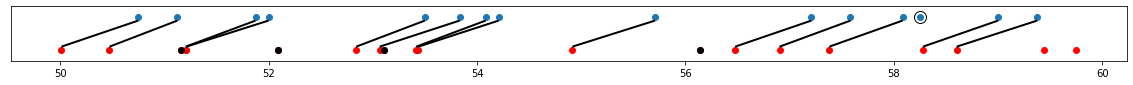

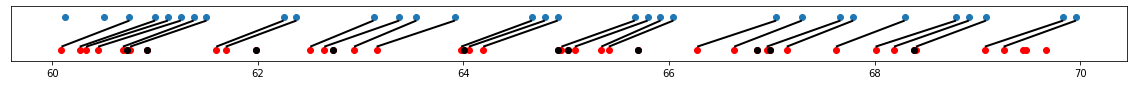

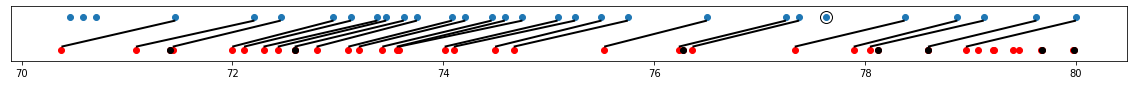

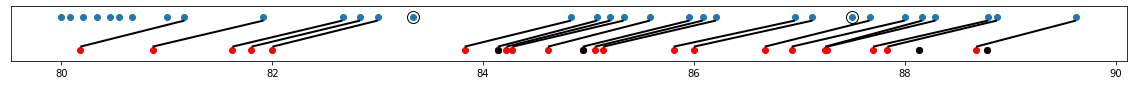

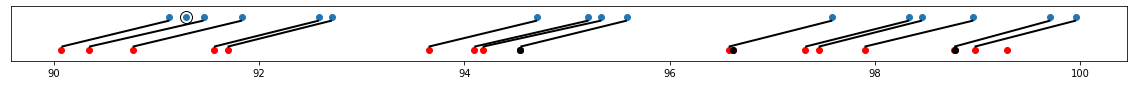

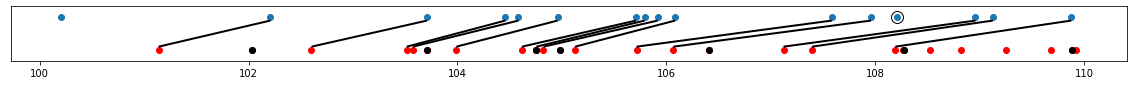

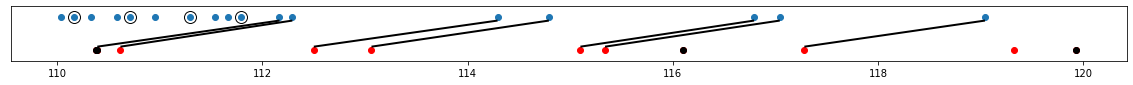

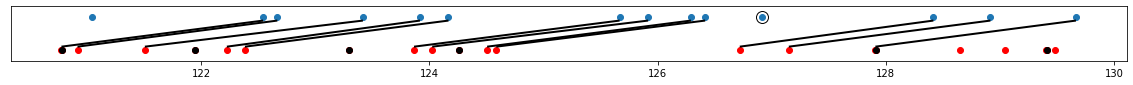

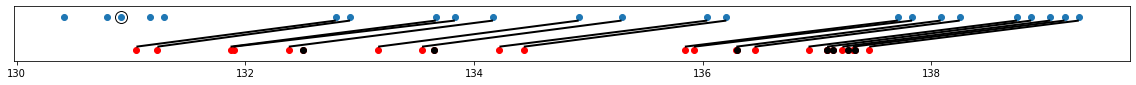

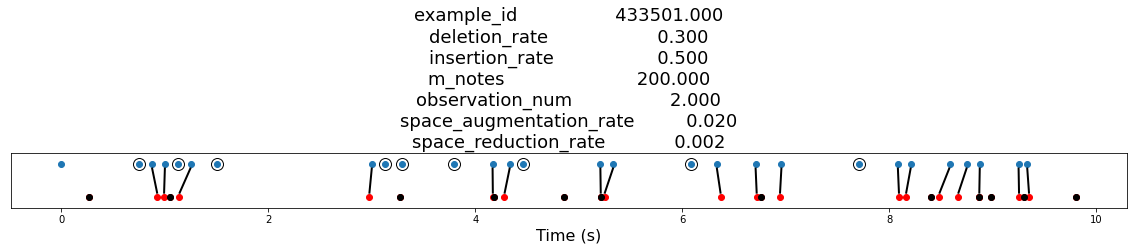

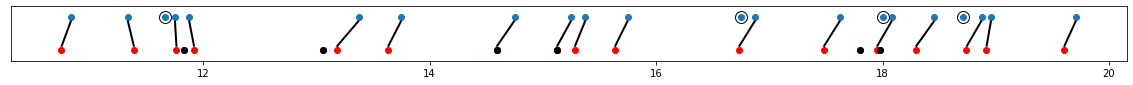

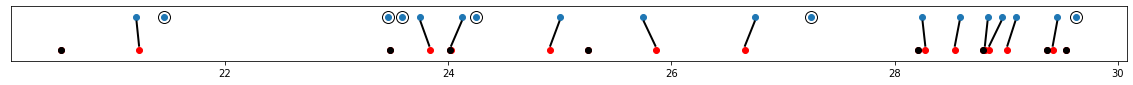

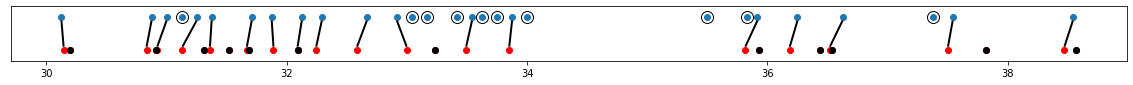

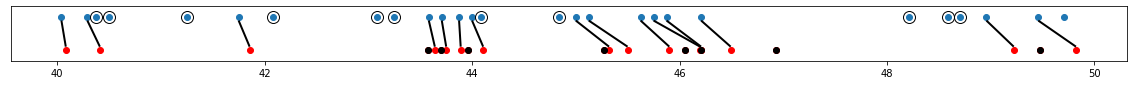

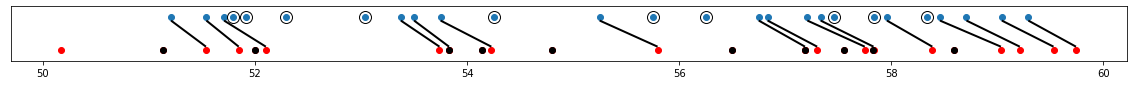

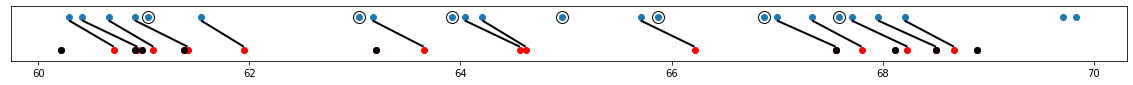

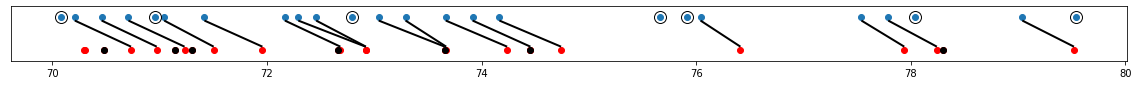

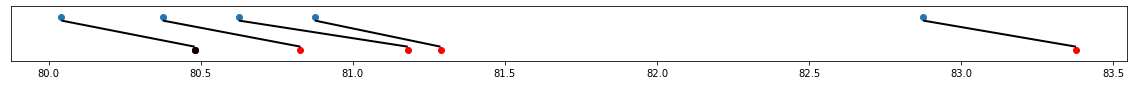

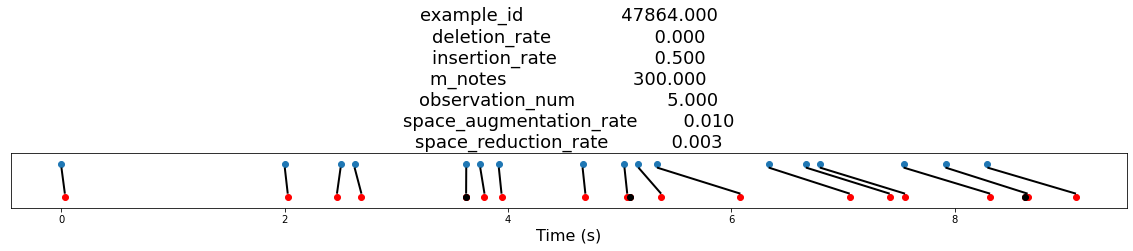

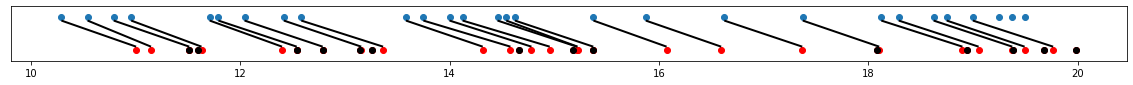

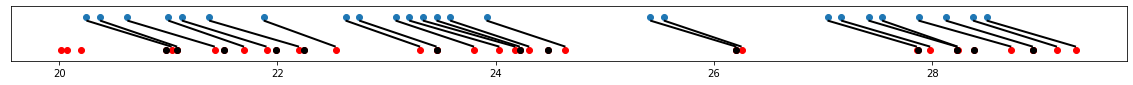

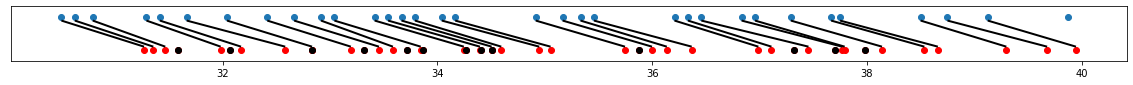

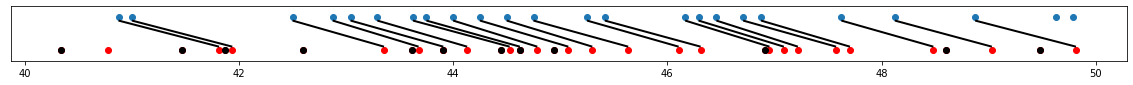

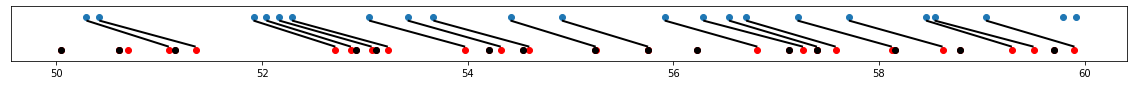

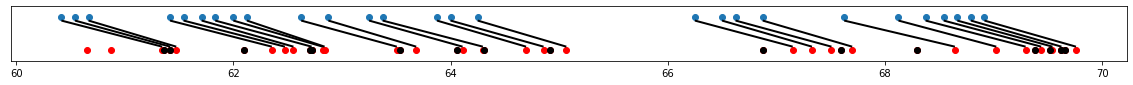

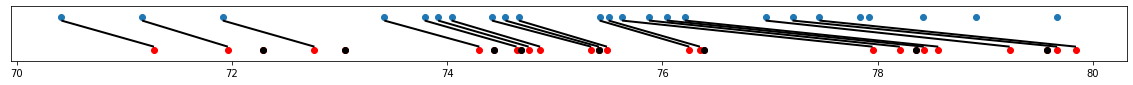

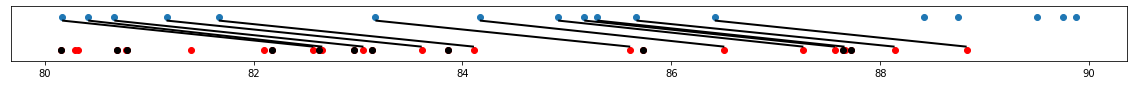

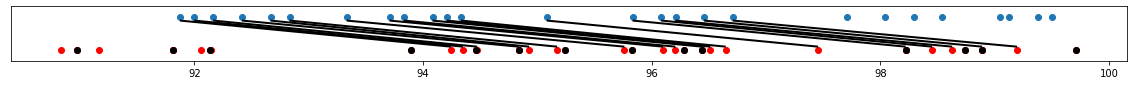

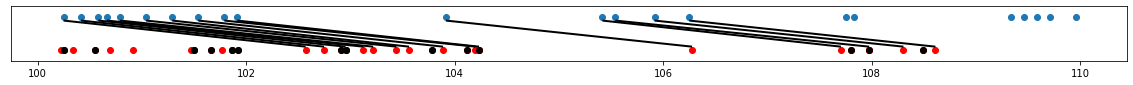

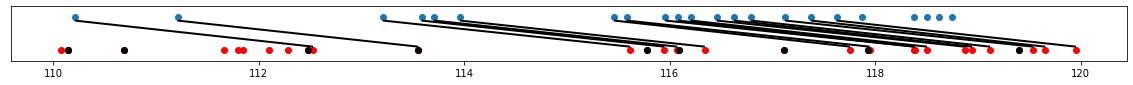

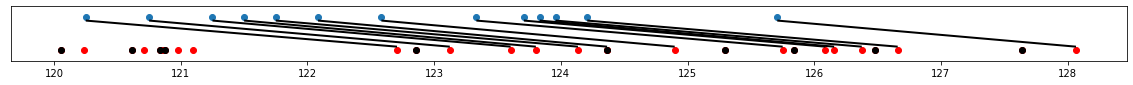

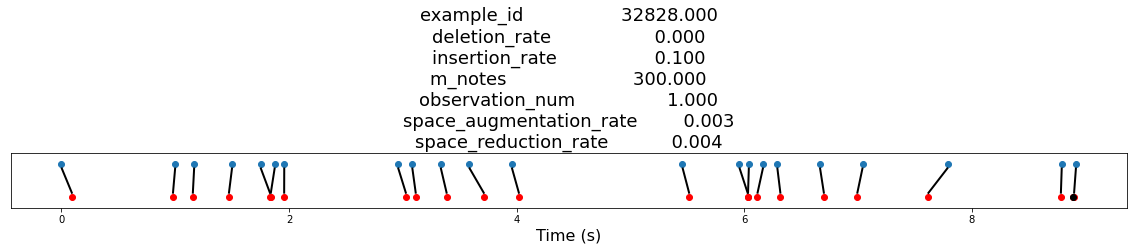

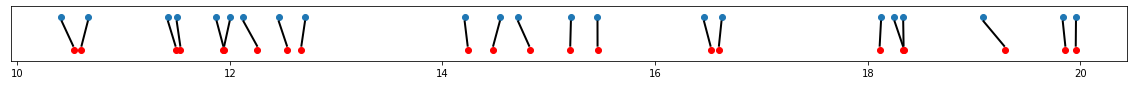

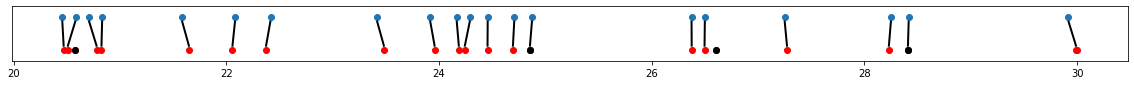

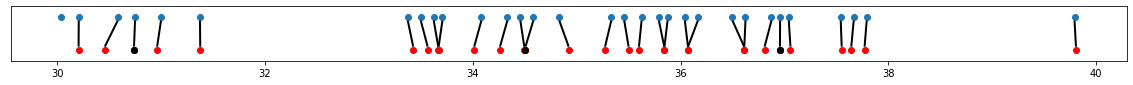

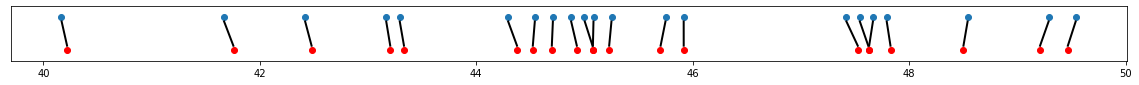

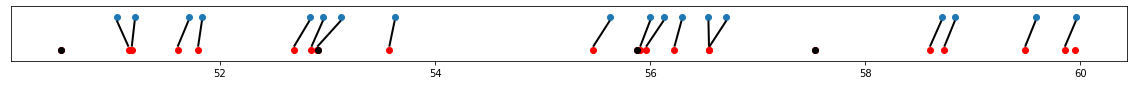

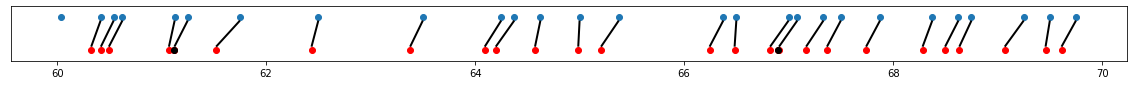

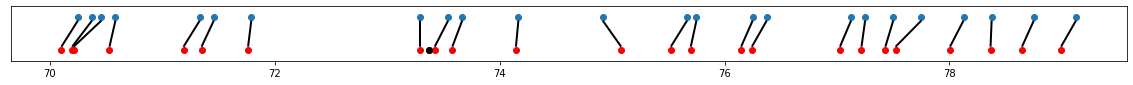

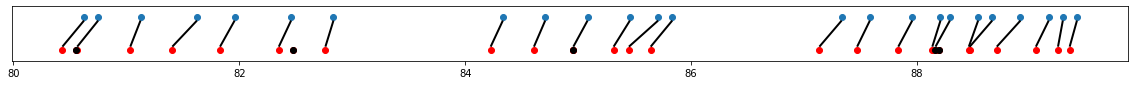

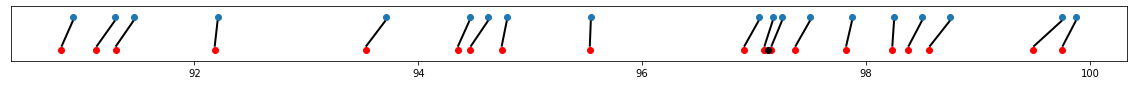

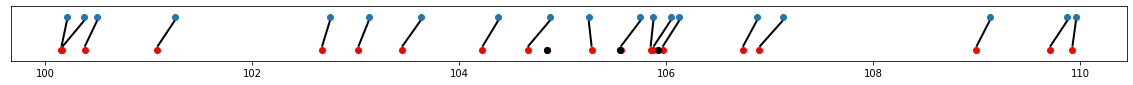

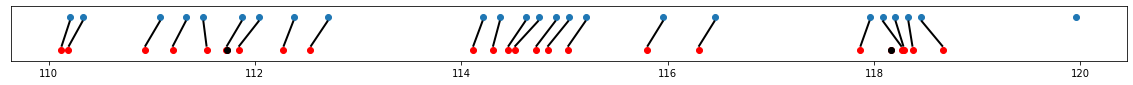

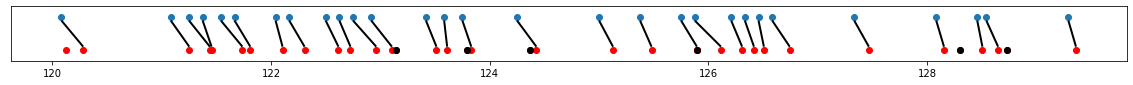

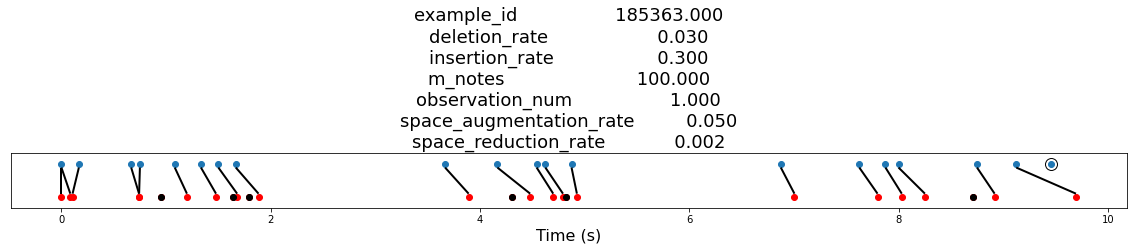

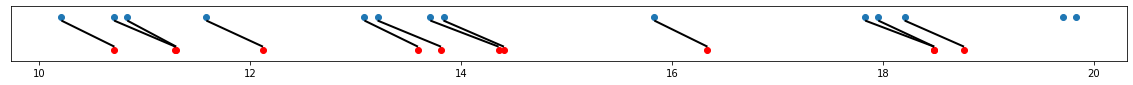

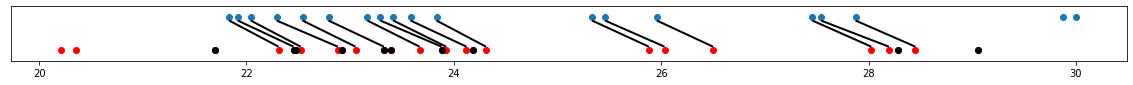

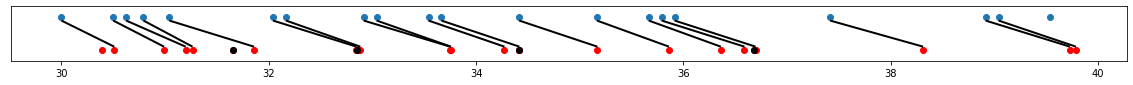

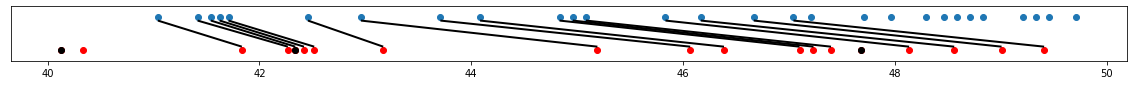

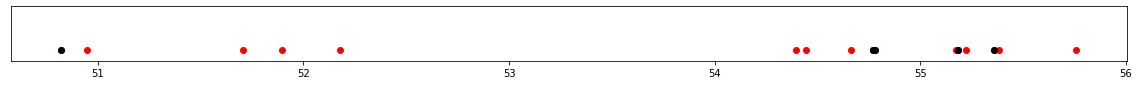

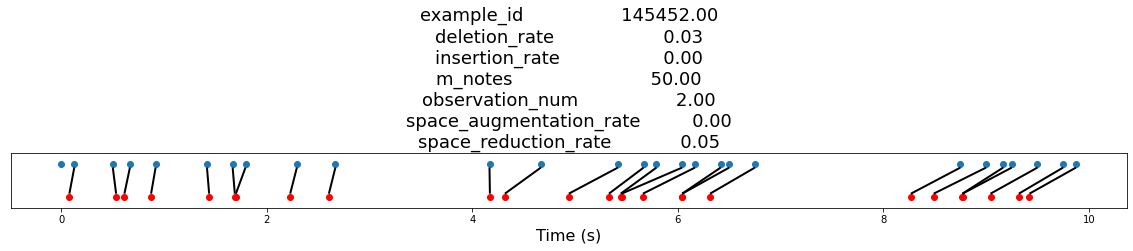

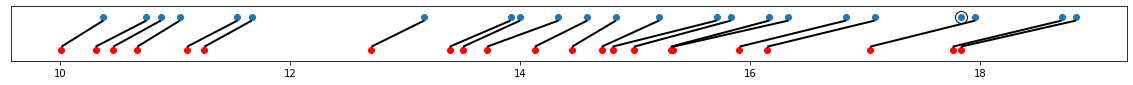

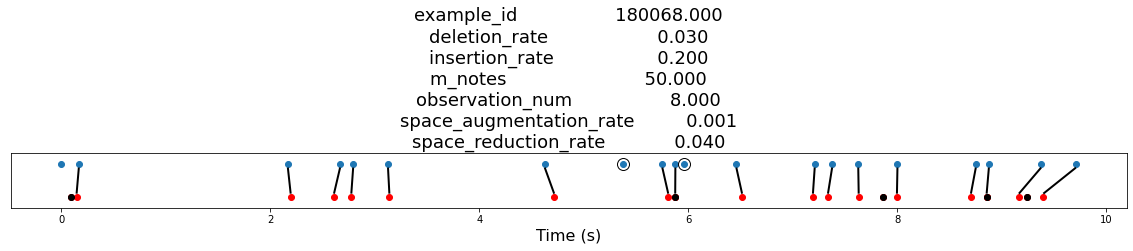

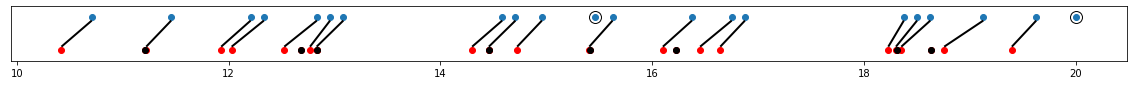

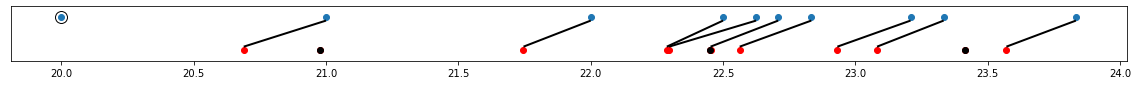

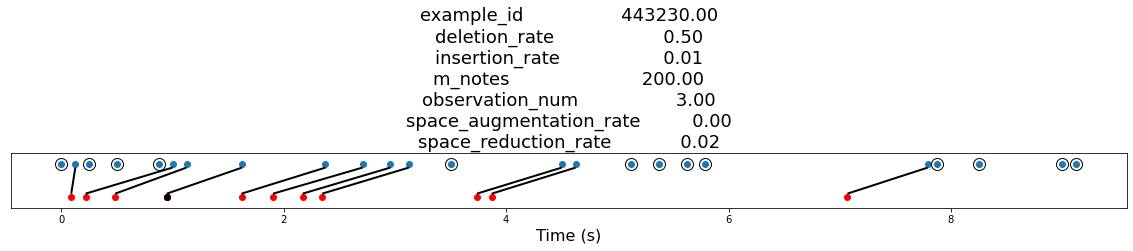

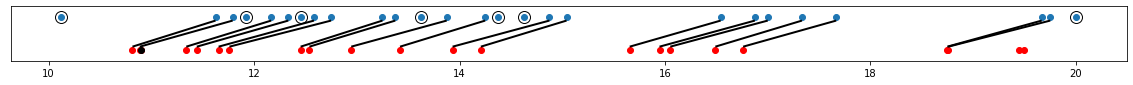

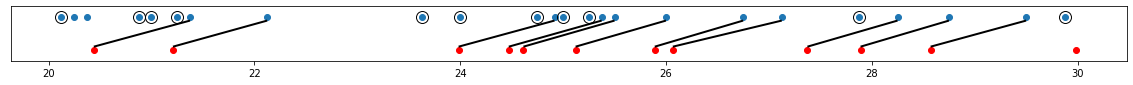

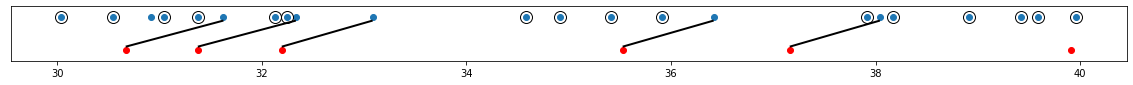

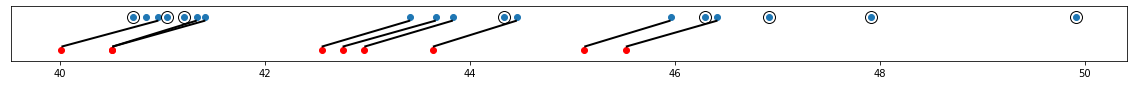

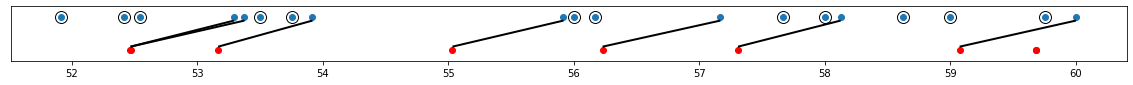

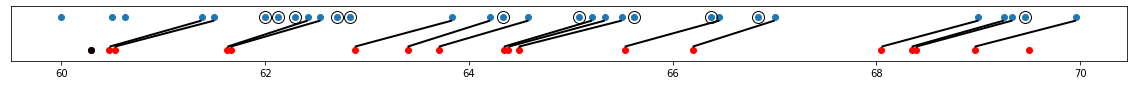

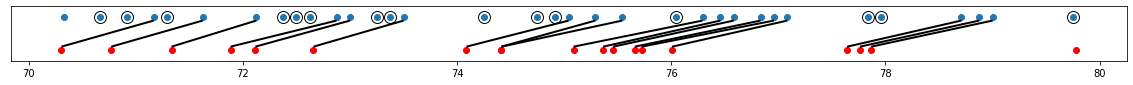

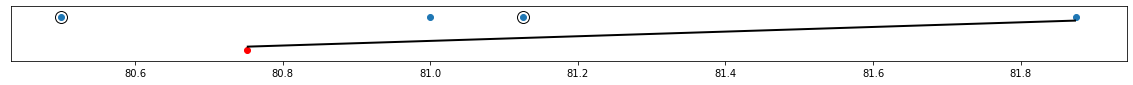

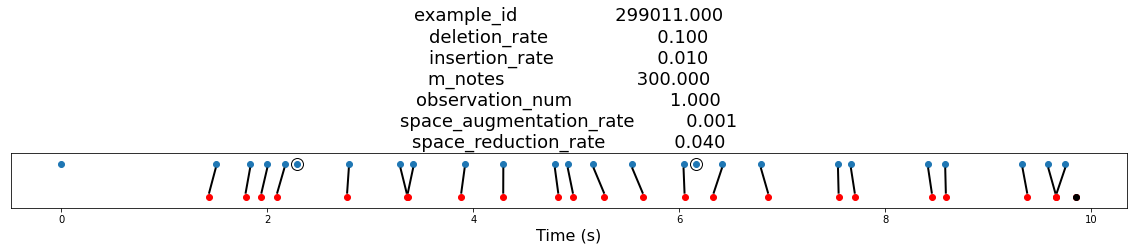

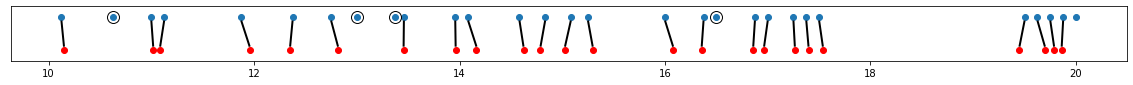

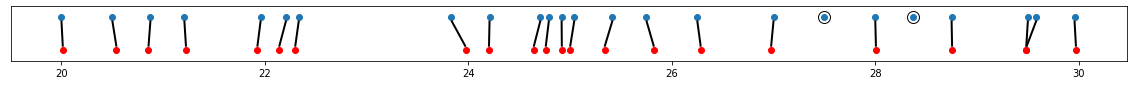

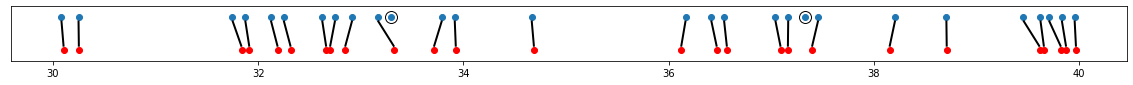

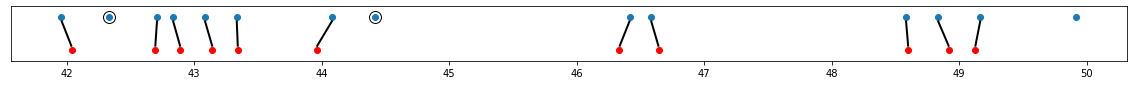

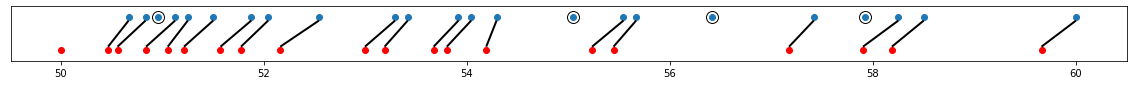

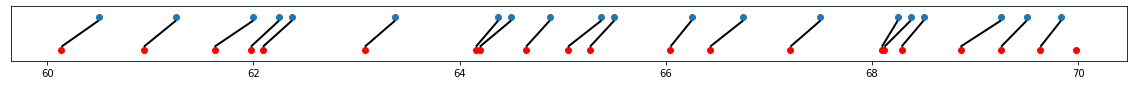

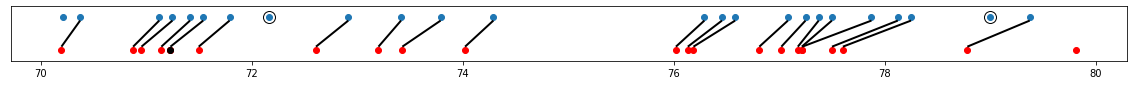

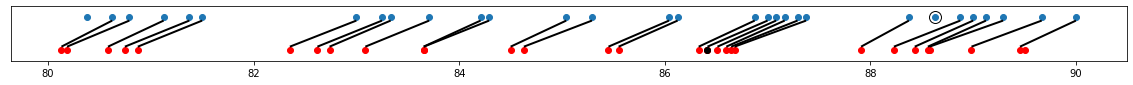

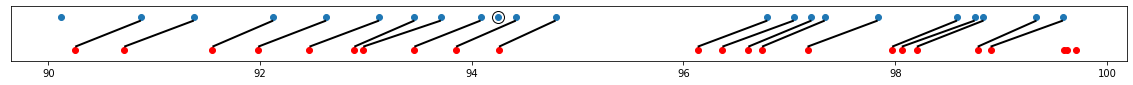

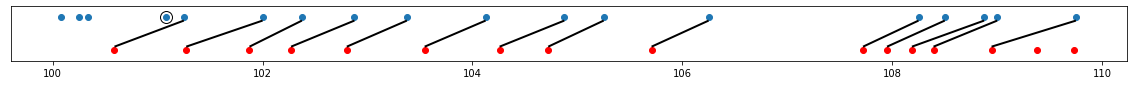

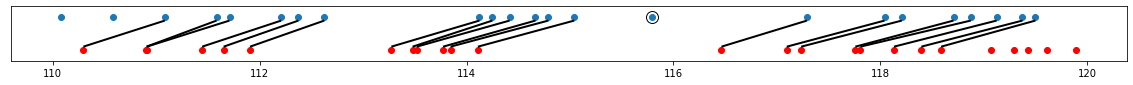

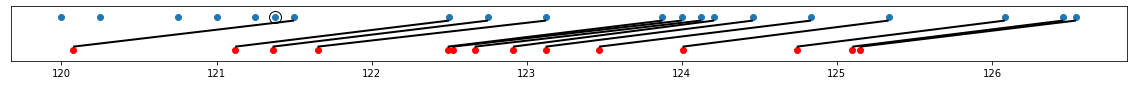

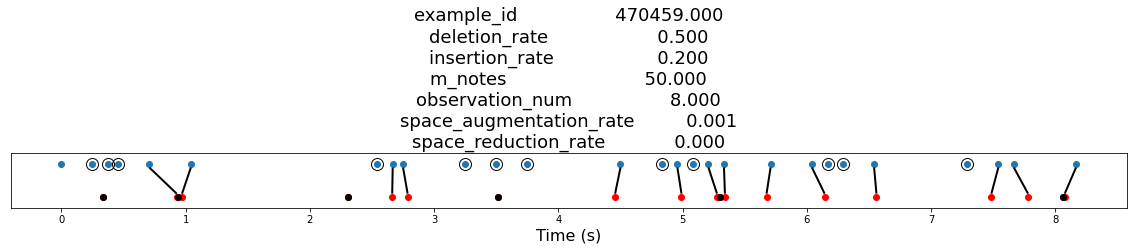

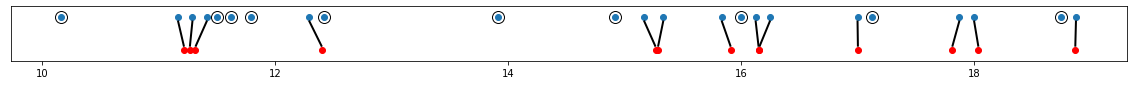

In [3]:
np.random.seed(RANDOM_SEED)
shuffle_permutation = np.random.permutation(len(example_set))
shuffled_example_set = example_set[shuffle_permutation]
shuffled_parameter_table = parameter_table.iloc[shuffle_permutation].reset_index(drop=False)

for i in range(10):
    m, t, matchings = shuffled_example_set[i]
    params = shuffled_parameter_table.iloc[i]

    max_seconds = max(max(m), max(t))
    max_seconds = math.ceil(max_seconds / 10) * 10

    for start_seconds in range(0, max_seconds, 10):
        if start_seconds == 0:
            params_row_str = str(params)
            title = params_row_str[params_row_str[params_row_str.find('\n'): ].find('\n'): params_row_str.rfind('\n')]
            x_label = None
        else:
            title = ''
            x_label = ''

        nbt.plot_matching(m, t, matchings, time_range=(start_seconds, start_seconds+10), title=title, x_label=x_label)